In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import cv2


def load_and_preprocess(folder_path):
  # Iterate through all the images in the folder
  for filename in os.listdir(folder_path):
      if filename.endswith(".png"):
          # Load the X-ray image
          image = Image.open(os.path.join(folder_path, filename))

          # Noise Reduction: Gaussian Blur
          blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

          # Edge Detection: Canny Edge Detector
          edges = cv2.Canny(blurred_image, 50, 150)

          # Find contours
          contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

          # Draw contours on a blank image
          contour_img = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
          cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)

          roi = contour_img[14:255 , 20:282]

          return roi

In [ ]:
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow import keras

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_path = "/content/drive/MyDrive/Train_withoutMask"
test_path = "/content/drive/MyDrive/Test_withoutMask"

batch_size = 32

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    preprocessing_function=load_and_preprocess(train_path)
)

test_datagen = ImageDataGenerator(rescale=1./255,preprocessing_function=load_and_preprocess(test_path))

# Train/validation generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [ ]:
from keras.callbacks import EarlyStopping
es=EarlyStopping(monitor='val_loss', mode='max', verbose=1, patience=3)


In [ ]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping


# Load pre-trained Densenet201 model
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Create model
model = Model(inputs=base_model.input, outputs=output)

learning_rate = 0.0001
# Define the optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
H = model.fit(train_generator, validation_data=validation_generator, epochs=10, verbose=1, callbacks=[es])

Epoch 1/10
50/50 [==============================] - 602s 12s/step - loss: 0.2224 - accuracy: 0.9394 - val_loss: 0.1396 - val_accuracy: 0.9500
Epoch 2/10
50/50 [==============================] - 572s 11s/step - loss: 0.0259 - accuracy: 0.9887 - val_loss: 0.1214 - val_accuracy: 0.9650
Epoch 3/10
50/50 [==============================] - 564s 11s/step - loss: 0.0105 - accuracy: 0.9962 - val_loss: 0.1271 - val_accuracy: 0.9675
Epoch 4/10
50/50 [==============================] - 562s 11s/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.1361 - val_accuracy: 0.9625
Epoch 4: early stopping


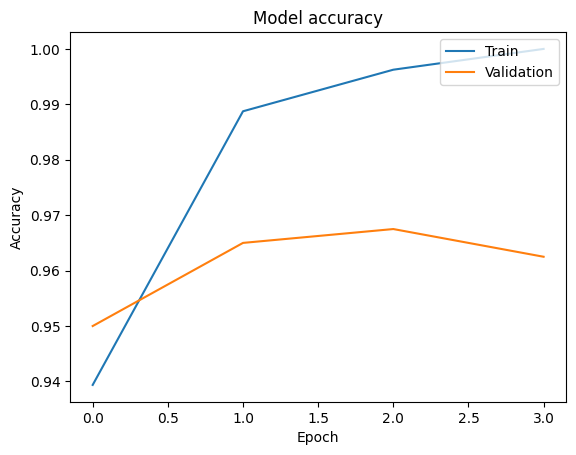

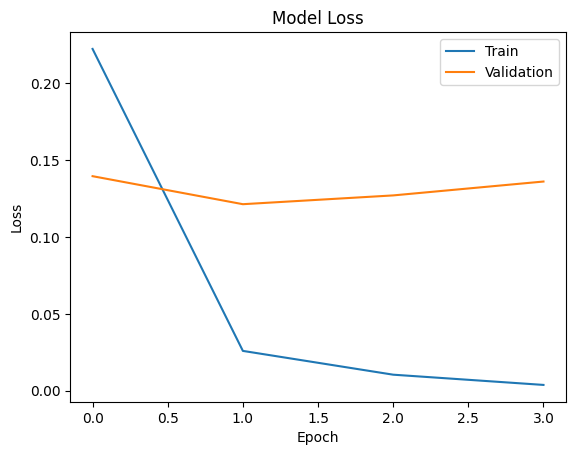

In [ ]:
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [ ]:
drive_path = '/content/drive/My Drive/'
model.save(drive_path+'ROI_Densenet201.h5')

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_binary = (y_pred > 0.5).astype(int)
conf_matrix = confusion_matrix(y_true, y_pred_binary)
class_report = classification_report(y_true, y_pred_binary)
print("Classification Report:\n", class_report)

7/7 [==============================] - 90s 10s/step
Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.52      0.52       100
           1       0.52      0.51      0.51       100

    accuracy                           0.52       200
   macro avg       0.52      0.52      0.51       200
weighted avg       0.52      0.52      0.51       200



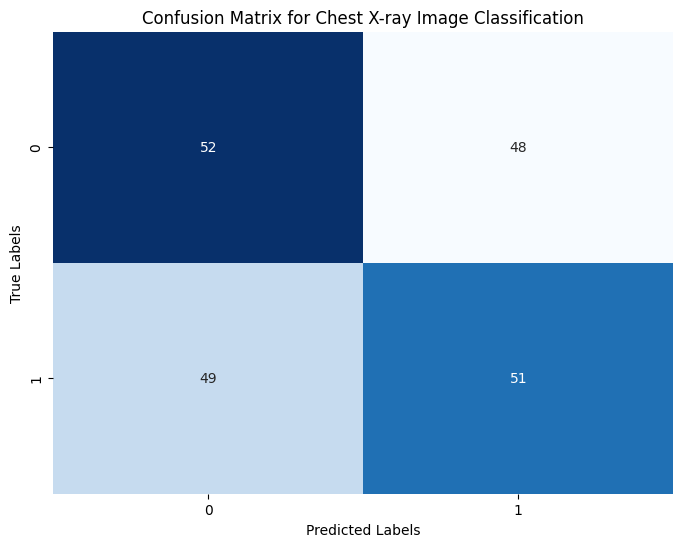

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Chest X-ray Image Classification')
plt.show()